# Rank reversals

This tutorial provides an overview of the use of the scikit-criteria ranking comparison tools.

## Context and motivation

Multi-criteria decision methods may present irregularities in their rankings that compromise the reliability of their results.
Depending on how the alternatives are defined and evaluated in a problem, rank reversals are classified in five types.
To evaluate the robustness of these methods, Wang & Triantaphyllou (2006) proposed three test criteria that cover all five kinds of rank reversals.

1. **Rank invariance**: The rank of an optimal alternative must remain invariant when a sub-optimal alternative is worsened.
2. **Transitivity**: when a decision problem is partitioned in smaller sub-problems, the relative transitivity of alternatives must be retained.
2. **Recomposition consistency**: a new ranking constructed from a set of smaller sub-problems must be equivalent to the ranking obtained from running the original method.

## Rank reversal checking in scikit-criteria

In scikit-criteria we implement rank reversal checking via the classes `RankInvariantChecker` and `TransitivityChecker`, which are available in the `skcriteria.ranksrev` module. Rank reversal checkers take an MCDM as a parameter, along with other relevant information, and implement an `evaluate()` method against a specific decision matrix.

In the following sections we'll review the usage of each checker to verify the validity of some example MCDMs.

## Test criterion 1 - Rank Invariance

Test criterion 1 evaluates the stability of an MCDM method's top-ranked alternative under minor degradations of non-optimal alternatives, which roughly attempts to detect rank reversals due to irrelevant changes.

In its most basic form, the `RankInvariantChecker` works by worsening each sub-optimal alternative by a chosen amount `repeat` times, and stores every result in a `RanksComparator`.

### Experiment setup (TODO: make this a propper example)

In [ ]:
import skcriteria as skc
from skcriteria.pipeline import mkpipe
from skcriteria.preprocessing.invert_objectives import InvertMinimize
from skcriteria.preprocessing.scalers import SumScaler, VectorScaler
from skcriteria.preprocessing.filters import FilterNonDominated
from skcriteria.agg.simple import WeightedSumModel

method = mkpipe(
    InvertMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    WeightedSumModel(),
)

# Load Van 2021 Evaluation Dataset of cryptocurrencies
dm = skc.datasets.load_van2021evaluation(windows_size=7)

In [ ]:
from skcriteria.ranksrev import RankInvariantChecker

checker1 = RankInvariantChecker(dmaker=method, repeat=10, random_state=42)
# results1 = checker1.evaluate(dm)

## Test criterions 2 & 3 - Transitivity and Recomposition Consistency

Test criterions 2 and 3 are closely connected in their goal of evaluating the internal consistency and robustness MCDMs via problem decomposition.

- **Test Criterion 2 (Transitivity):**  Ensures that transitivity holds across pairwise comparisons that is, if alternative $A_1 \succ A_2$, and $A_2 \succ A_3$, then $A_1 \succ A_3$.
- **Test Criterion 3 (Recomposition Consistency):** Builds a total ordering from pairwise relationships to recompose them into a complete global ranking for comparison against the original ranking.

Because of this similarity, we opted to unify both criteria into a single class `TransitivityChecker`, that runs both tests secuentially and yields all the relevant details about the test criterions that were encountered in the process.

### Example failing both test cases

For this example we'll use a dataset proposed by Poh & Ang (1999) in search of alternative fuels for land transportation in Singapore.

In [2]:
import skcriteria as skc
from skcriteria.pipeline import mkpipe
from skcriteria.preprocessing.scalers import SumScaler, VectorScaler
from skcriteria.preprocessing.invert_objectives import InvertMinimize
from skcriteria.preprocessing.filters import FilterNonDominated
from skcriteria.agg.similarity import TOPSIS
from skcriteria.ranksrev.transitivity_check import TransitivityChecker

In [8]:
# Create a decision matrix
dm = skc.mkdm(
    matrix=[
        [4.57, 4.64, 62.2, 43.8, 8.49, 65.7],
        [65.7, 67.3, 6.03, 43.8, 4.25, 9.42],
        [20.3, 14.0, 20.2, 6.25, 58.3, 20.3],
        [9.42, 14.0, 11.5, 6.25, 29.0, 4.57]
    ],
    objectives=[max, max, max, max, max, max],
    alternatives=["status quo", "oil & ev", "oil & ngv", "methanol"],
    criteria=["supply", "emission", "tech", "safety", "cost", "consumer preference"]
)

To pick our best choice, we'll use a TOPSIS based method and print the resulting ranking.

In [9]:
# Define TOPSIS pipeline
topsis_pipe = mkpipe(
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    TOPSIS()
)

# Get original ranking
original_result = topsis_pipe.evaluate(dm)
print("Original TOPSIS ranking:")
print(f"Alternatives: {original_result.alternatives}")
print(f"Ranks: {original_result.rank_}")

Original TOPSIS ranking:
Alternatives: ['status quo' 'oil & ev' 'oil & ngv' 'methanol']
Ranks: [2 1 3 4]


To verify that we made the right choice picking TOPSIS, we'll be using the `TransitivityChecker`.
As we stated before, for this we'll need our original pipeline, but we also add two extra parameters:

* `allow_missing_alternatives`: desicion maker pipelines can sometimes return rankings with fewer alternatives than the original ones (using a pipeline that implements a filter, for example), which could cause issues in some partitions. This parameter allows for missing alternatives in a ranking to be added with a value of the maximum value of the ranking obtained + 1.

* `max_ranks`: limits the amount of rankings that can be constructed during the recomposition phase.

In [11]:
checker = TransitivityChecker(
    topsis_pipe, allow_missing_alternatives=True, max_ranks=10
)

In [12]:
results = checker.evaluate(dm=dm)

print("Transitivity Analysis Results:")
print(f"Test Criterion 2 (Transitivity): {results.extra_['test_criterion_2']}")
print(
    f"Test Criterion 3 (Recomposition Consistency): {results.extra_['test_criterion_3']}"
)
print(
    f"Transitivity Break Rate: {results.extra_['transitivity_break_rate']:.4f}"
)

Transitivity Analysis Results:
Test Criterion 2 (Transitivity): Not Passed
Test Criterion 3 (Recomposition Consistency): Not Passed
Transitivity Break Rate: 0.5000


The `TransitivityChecker` evaluation provides several key pieces of information:

1. **Test Criterion 2 Result**: Indicates whether the method maintains transitivity across all pairwise comparisons
2. **Test Criterion 3 Result**: Shows whether the recomposed ranking matches the original ranking
3. **Transitivity Break Rate**: A normalized measure of how many transitivity violations exist relative to the theoretical maximum.

Given that our pipeline failed the test, we should be able to see many different rankings of our original desicion matrix.

In [13]:
print("Ranking Comparison:")

items = list(results.named_ranks.items())
for rank_name, ranking in items[:4]:
    print(f"\n{rank_name}:")
    for alt, rank_val in zip(ranking.alternatives, ranking.rank_):
        print(f"  {alt:25} → rank {rank_val}")

Ranking Comparison:

Original:
  status quo                → rank 2
  oil & ev                  → rank 1
  oil & ngv                 → rank 3
  methanol                  → rank 4

Recomposition1:
  status quo                → rank 1
  oil & ev                  → rank 2
  oil & ngv                 → rank 3
  methanol                  → rank 4

Recomposition2:
  status quo                → rank 3
  oil & ev                  → rank 1
  oil & ngv                 → rank 2
  methanol                  → rank 4

Recomposition3:
  status quo                → rank 2
  oil & ev                  → rank 3
  oil & ngv                 → rank 1
  methanol                  → rank 4


### Example that passes both tests

In [6]:
# Create a decision matrix for energy alternatives
dm = skc.datasets.load_simple_stock_selection()

# Define TOPSIS pipeline
ws_pipe = mkpipe(
    InvertMinimize(),
    FilterNonDominated(),
    TOPSIS()
)

# Get original ranking
original_result = topsis_pipe.evaluate(dm)
print("Original TOPSIS ranking:")
print(f"Alternatives: {original_result.alternatives}")
print(f"Ranks: {original_result.rank_}")

# Create the transitivity checker
checker = TransitivityChecker(ws_pipe,
                              allow_missing_alternatives=True,
                              max_ranks=1000)

# Run the transitivity evaluation
results = checker.evaluate(dm=dm)

print("\nTransitivity Analysis Results:")
print(f"Test Criterion 2 (Transitivity): {results.extra_['test_criterion_2']}")
print(
    f"Test Criterion 3 (Recomposition Consistency): {results.extra_['test_criterion_3']}"
)
print(
    f"Transitivity Break Rate: {results.extra_['transitivity_break_rate']:.4f}"
)

Original TOPSIS ranking:
Alternatives: ['PE' 'JN' 'AA' 'FX' 'MM' 'GN']
Ranks: [3 5 2 6 4 1]

Transitivity Analysis Results:
Test Criterion 2 (Transitivity): Passed
Test Criterion 3 (Recomposition Consistency): Passed
Transitivity Break Rate: 0.0000


/home/paula/Desktop/PhD/scikit/lib/python3.12/site-packages/skcriteria/agg/similarity.py:127: UserWarning: Although TOPSIS can operate with minimization objectives, this is not recommended. Consider reversing the weights for these cases.
  warnings.warn(


The plot below shows the ranking results for each alternative, with confidence intervals indicating the stability of rankings across different evaluation scenarios. The dashed line connects the mean ranks to visualize potential transitivity issues in the decision matrix.

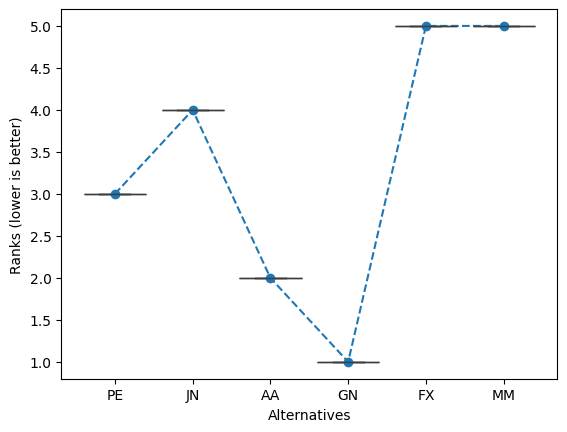

In [7]:
import matplotlib.pyplot as plt
results.plot()
plt.plot(results[0],marker='o',linestyle='--')
plt.show()

### Untying and Recomposition strategies

## References

- Wang & Triantaphyllou (2006). Ranking Irregularities When Evaluating Alternatives by Using Some Multi- Criteria Decision Analysis Methods.
- Poh & Ang (1999). Transportation fuels and policy for Singapore: an AHP planning approach.